<a href="https://colab.research.google.com/github/seyma-tas/image-classification-project/blob/master/27_x_ray_pneumonia_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', color_codes=True)

import os
import datetime
# import pydot

from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import plot_model
from keras.models import Sequential
from keras.regularizers import l1_l2
from keras.applications.vgg16 import VGG16

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

Using TensorFlow backend.


In [ ]:
# Function to create a dictionary of model's train, validation and test results


def store_results_to_dict(model, model_description):
    train_loss, train_acc = model.evaluate_generator(train_generator, steps=train_steps_per_epoch)
    val_loss, val_acc = model.evaluate_generator(val_generator, steps=val_steps_per_epoch)
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_steps_per_epoch)
    
    curr_dict = { 'Model':model_description
                 ,'Train Accuracy': train_acc
                 ,'Train Loss': train_loss
                 ,'Validation Accuracy':val_acc
                 ,'validation Loss':val_loss
                 ,'Test Accuracy':test_acc
                 ,'Test Loss':test_loss
                  }
    return curr_dict

In [ ]:
def plot_acc_and_loss(model_history):
  acc = model_history.history['acc']
  val_acc = model_history.history['val_acc']
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  epochs = range(len(acc))
  plt.figure(figsize=(16,7))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy',fontsize=20 )
  plt.legend()
  plt.figure(figsize=(16,7))
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and validation loss', fontsize=20)
  plt.legend()
  plt.show()

In [ ]:
train_data_dir=('/content/drive/My Drive/image-classification-project/data/train')
val_data_dir=('/content/drive/My Drive/image-classification-project/data/val')
test_data_dir=('/content/drive/My Drive/image-classification-project/data/test')

In [ ]:
path='/content/drive/My Drive/image-classification-project/data/'
# Numbers of pneumonia and normal images in each set
for folder in ['train', 'val', 'test']:
    n_normal = len(os.listdir(path + folder + '/NORMAL'))
    n_pneumonia = len(os.listdir(path + folder + '/PNEUMONIA'))
    print("There are {} normal x-ray images and {} pnemonia x-ray images in {} set. ".format(n_normal, n_pneumonia, folder))

There are 930 normal x-ray images and 2615 pnemonia x-ray images in train set. 
There are 331 normal x-ray images and 833 pnemonia x-ray images in val set. 
There are 321 normal x-ray images and 827 pnemonia x-ray images in test set. 


In [ ]:
total_images_train_normal = os.listdir(path + 'train/NORMAL')
total_images_train_pneumonia = os.listdir(path + 'train/PNEUMONIA')

total_images_test_normal = os.listdir(path + 'test/NORMAL')
total_images_test_pneumonia = os.listdir(path + 'test/PNEUMONIA')

total_images_val_normal = os.listdir(path + 'val/NORMAL')
total_images_val_pneumonia = os.listdir(path + 'val/PNEUMONIA')

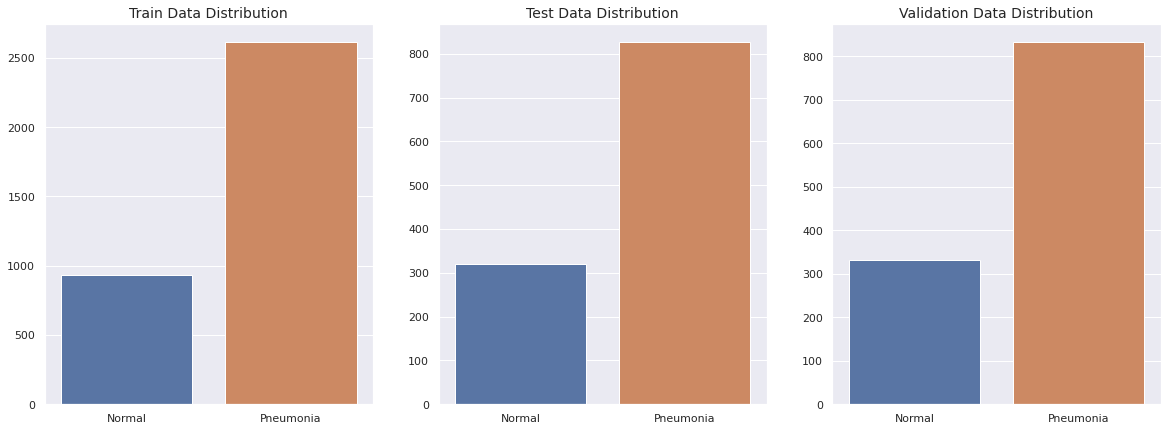

In [ ]:
plt.figure(figsize=(20, 7))
plt.subplot(131)
plt.title('Train Data Distribution', fontsize=14)
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])
plt.subplot(132)
plt.title('Test Data Distribution', fontsize=14)
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_test_normal),len(total_images_test_pneumonia)])
plt.subplot(133)
plt.title('Validation Data Distribution', fontsize=14)
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_val_normal),len(total_images_val_pneumonia)])
plt.show()

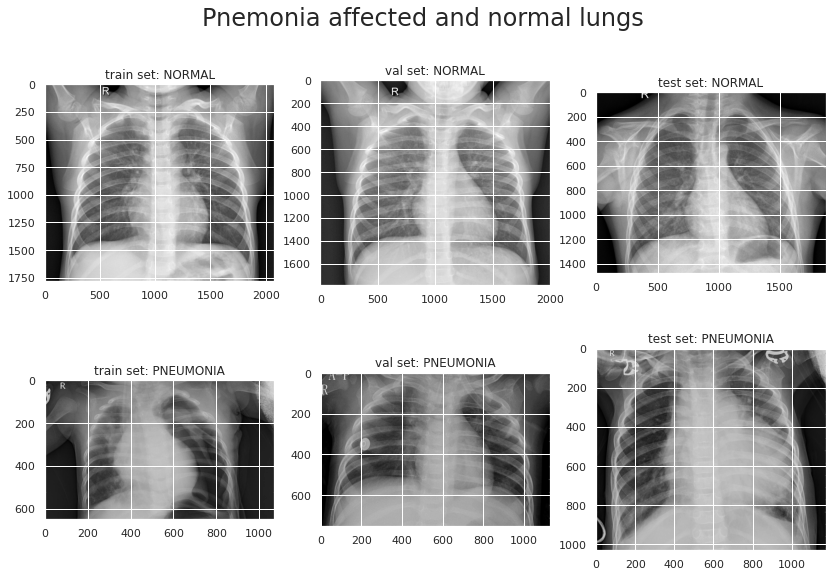

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(14, 9))
ax = ax.ravel()

fig.suptitle('Pnemonia affected and normal lungs', fontsize=24)

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('{} set: NORMAL'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('{} set: PNEUMONIA'.format(_set))


In [ ]:
# Get all the data in the directory DATA/TRAIN, and reshape them
print("Train data:")
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_data_dir,
                                                                         target_size=(150, 150), batch_size=32, class_mode='binary')

# Get all the data in the directory DATA/TEST , and reshape them    
print("Test data:")                                                                  
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_data_dir,
                                                                        target_size=(150, 150), batch_size=32, class_mode='binary')

# Get all the data in the directory DATA/VAL, and reshape them
print("Validation data:")  
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_data_dir,
                                                                       target_size=(150, 150), batch_size=32, class_mode='binary')

Train data:
Found 3543 images belonging to 2 classes.
Test data:
Found 1148 images belonging to 2 classes.
Validation data:
Found 1162 images belonging to 2 classes.


In [ ]:
train_steps_per_epoch = np.math.ceil(train_generator.samples / train_generator.batch_size)
val_steps_per_epoch = np.math.ceil(val_generator.samples / val_generator.batch_size)
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

# Baseline Model

In [ ]:

#Baseline Model
model0 = Sequential()

# Fist Conv layer with 32 filters,3 by 3 window, input size 150 by 150 by 3 for RGB as third dimension
model0.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
#First Max Pooling  layer with window 2 by 2
model0.add(MaxPooling2D(pool_size = (2, 2)))

#  Second Conv layer with filter =64, window=3 by 3 
model0.add(Conv2D(64, (3, 3), activation="relu"))
# 2d Pooling layer with window 2 by 2
model0.add(MaxPooling2D(pool_size = (2, 2)))

# Third Conv layer with 128 features, window=3 by 3
model0.add(Conv2D(128, (3, 3), activation='relu'))
# 3rd Pooling layer with window 2 by 2
model0.add(MaxPooling2D((2, 2)))

# Forth Conv layer with 128 features, window=3 by 3
model0.add(Conv2D(128, (3, 3), activation='relu'))
# 4th Pooling layer with window 2 by 2
model0.add(MaxPooling2D((2, 2)))

# Flatten the layer
model0.add(Flatten())

# Fully Connected Layers
# single dense layer with 512 neurons
model0.add(Dense(activation = 'relu', units = 512))

#single output layer with one neuron since we only want to predict two classes
model0.add(Dense(activation = 'sigmoid', units = 1))
model0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

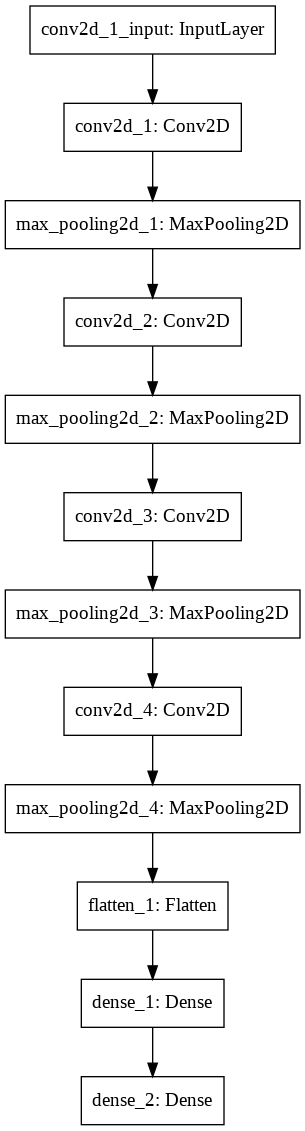

In [ ]:
#structure of Base model
plot_model(model0)
# looking at the structure of my neural network

In [ ]:
# Compile the Neural network
model0.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4), ### learning rate 0.0001
              metrics=['acc'])


In [ ]:
# ⏰ This cell may take several minutes to run
start = datetime.datetime.now()
history = model0.fit_generator(train_generator, 
                              steps_per_epoch=train_steps_per_epoch, 
                              epochs=1, 
                              validation_data=val_generator, 
                              validation_steps=val_steps_per_epoch)
end = datetime.datetime.now()
elapsed = end - start
print('\n ---------Elapsed Time-----------')
print('Time to fit baseline model is:\n {}'.format(elapsed))

Epoch 1/1
111/111 [==============================] - 1950s 18s/step - loss: 0.4461 - acc: 0.7982 - val_loss: 0.7260 - val_acc: 0.7289

 ---------Elapsed Time-----------
Time to fit baseline model is:
 0:32:30.755058


In [ ]:
results=store_results_to_dict(model0, 'Base Model(with 4 conv,pooling layers,and dense full conv layer)')
results_final = []
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

NameError: ignored

In [ ]:
plot_acc_and_loss(history)


NameError: ignored

# Hyperparameter Tuned Model

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(8, (7, 7), padding='same', activation='relu', input_shape=(150,150, 3)))
cnn.add(Conv2D(8, (7, 7), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (3, 3)))

cnn.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
cnn.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (3, 3)))

cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))


cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

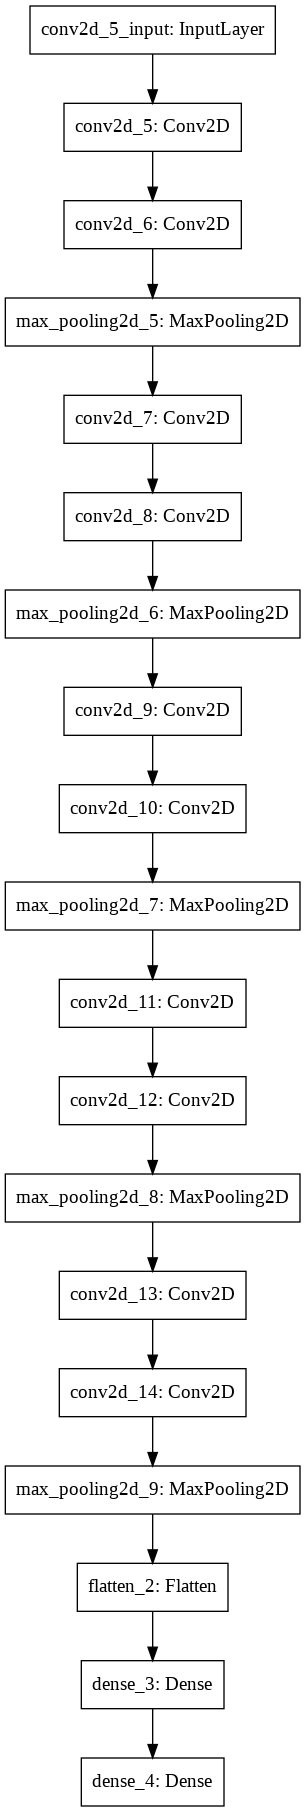

In [ ]:
#structure of Base model
plot_model(cnn)
# looking at the structure of my neural network

In [ ]:
optimizer = Adam(lr=0.0001, decay=1e-5)
cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 8)       1184      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 8)       3144      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 16)        3216      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 16)        6416      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)       

In [ ]:
start = datetime.datetime.now()
cnn_history = cnn.fit_generator(train_generator,
                                epochs=1,
                                steps_per_epoch=train_steps_per_epoch,
                                validation_data=val_generator, 
                                validation_steps=val_steps_per_epoch)
   
end = datetime.datetime.now()
elapsed = end - start
print('---------Elapsed Time-----------')
print('Time to fit tuned model is:\n {}'.format(elapsed))

Epoch 1/100
111/111 [==============================] - 62s 558ms/step - loss: 0.5939 - acc: 0.7338 - val_loss: 0.4840 - val_acc: 0.7160
Epoch 2/100
111/111 [==============================] - 57s 513ms/step - loss: 0.3829 - acc: 0.8140 - val_loss: 0.1892 - val_acc: 0.8898
Epoch 3/100
111/111 [==============================] - 57s 511ms/step - loss: 0.2340 - acc: 0.9043 - val_loss: 0.2211 - val_acc: 0.9114
Epoch 4/100
111/111 [==============================] - 57s 509ms/step - loss: 0.1830 - acc: 0.9314 - val_loss: 0.1140 - val_acc: 0.9621
Epoch 5/100
111/111 [==============================] - 57s 512ms/step - loss: 0.1428 - acc: 0.9469 - val_loss: 0.0801 - val_acc: 0.9639
Epoch 6/100
111/111 [==============================] - 56s 504ms/step - loss: 0.1245 - acc: 0.9483 - val_loss: 0.2838 - val_acc: 0.9604
Epoch 7/100
111/111 [==============================] - 57s 516ms/step - loss: 0.1067 - acc: 0.9610 - val_loss: 0.0083 - val_acc: 0.9699
Epoch 8/100
111/111 [===========================

In [ ]:
results=store_results_to_dict(cnn, 'Hyperparameter tuned model(padding, adam)')
# results_final = []
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Testing Accuracy,Testing Loss,Training Accuracy,Training Loss,Validation Accuracy,validation Loss
0,"Base Model(with 4 conv,pooling layers,and dens...",0.879073,1.138494,1.0,1.949158e-07,0.977820,9.190355e-04
1,"Hyperparameter tuned model(padding, adam)",0.848997,1.867431,1.0,1.860358e-06,0.977186,1.730812e-10


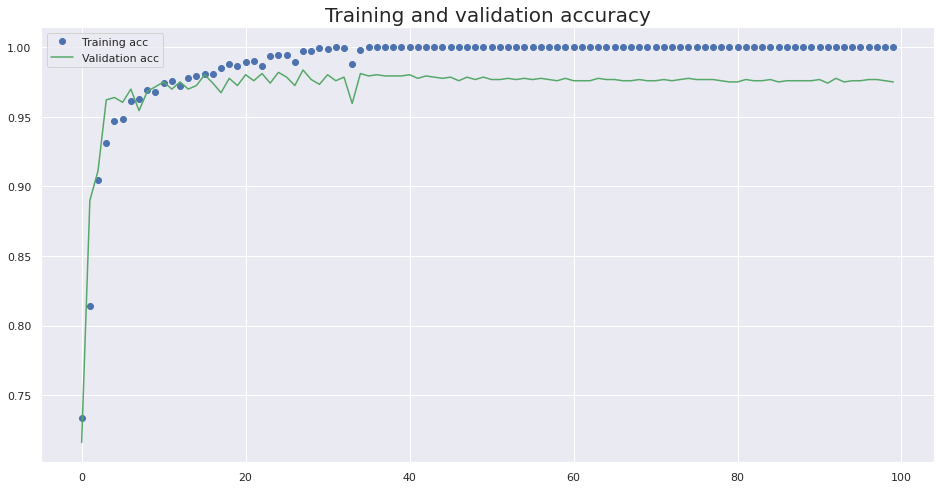

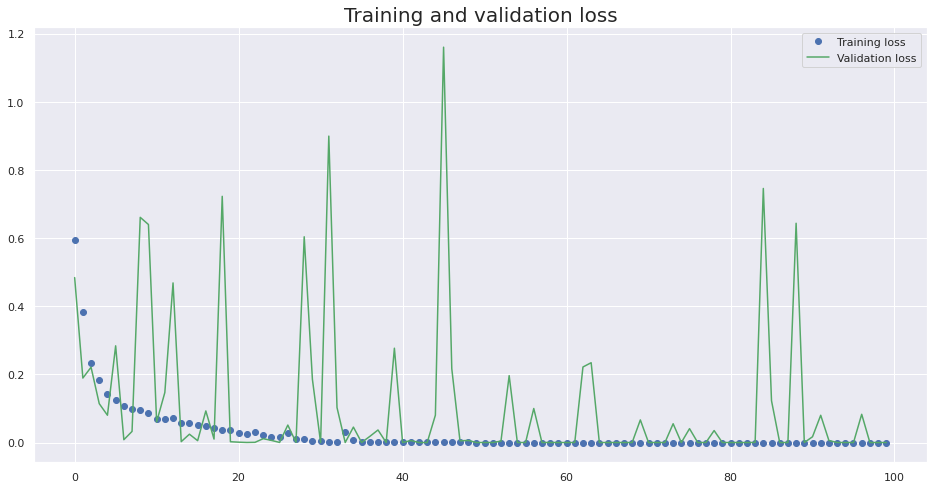

In [ ]:
plot_acc_and_loss(cnn_history)

# Regularized model(Dropout and Elasticnet)



In [ ]:
cnn = Sequential()
cnn.add(Conv2D(8, (7, 7), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2(), input_shape=(150, 150, 3)))
cnn.add(Conv2D(8, (7, 7), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(MaxPooling2D(pool_size = (3, 3)))

cnn.add(Conv2D(16, (5, 5), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Conv2D(16, (5, 5), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D(pool_size = (3, 3)))

cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2)))


cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.1))
cnn.add(Dense(1, activation='sigmoid'))

In [ ]:
optimizer = Adam(lr=0.0001, decay=1e-5)
cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
cnn.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 150, 150, 8)       1184      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 150, 150, 8)       3144      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 16)        3216      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 16)        6416      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 16)       

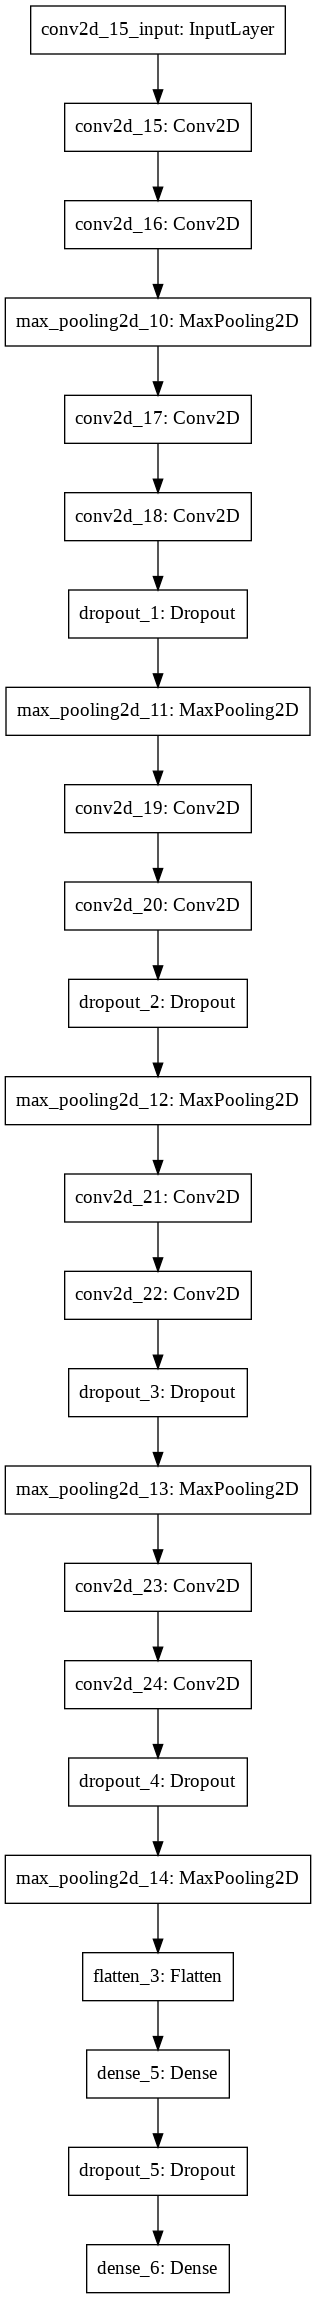

In [ ]:
plot_model(cnn)

In [ ]:
start = datetime.datetime.now()
cnn_history = cnn.fit_generator(train_generator,
                                epochs=1,
                                steps_per_epoch=train_steps_per_epoch,
                                validation_data=val_generator, 
                                validation_steps=val_steps_per_epoch)
end = datetime.datetime.now()
elapsed = end - start
print('---------Elapsed Time-----------')
print('Time to fit regularized model is:\n {}'.format(elapsed))

Epoch 1/100
111/111 [==============================] - 60s 544ms/step - loss: 82.3920 - acc: 0.7110 - val_loss: 66.5732 - val_acc: 0.7160
Epoch 2/100
111/111 [==============================] - 55s 493ms/step - loss: 53.6327 - acc: 0.7378 - val_loss: 41.5452 - val_acc: 0.7160
Epoch 3/100
111/111 [==============================] - 55s 499ms/step - loss: 31.9892 - acc: 0.7378 - val_loss: 23.5189 - val_acc: 0.7160
Epoch 4/100
111/111 [==============================] - 55s 496ms/step - loss: 16.9438 - acc: 0.7378 - val_loss: 11.7034 - val_acc: 0.7160
Epoch 5/100
111/111 [==============================] - 55s 495ms/step - loss: 8.1509 - acc: 0.7378 - val_loss: 5.5780 - val_acc: 0.7160
Epoch 6/100
111/111 [==============================] - 56s 509ms/step - loss: 4.1840 - acc: 0.7378 - val_loss: 2.9553 - val_acc: 0.7160
Epoch 7/100
111/111 [==============================] - 55s 493ms/step - loss: 2.2614 - acc: 0.7378 - val_loss: 1.7066 - val_acc: 0.7160
Epoch 8/100
111/111 [===================

In [ ]:
results=store_results_to_dict(cnn, 'Regularized Model(Dropout, Ridge-Lasso)')
# results_final = []
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Testing Accuracy,Testing Loss,Training Accuracy,Training Loss,Validation Accuracy,validation Loss
0,"Base Model(with 4 conv,pooling layers,and dens...",0.879073,1.138494,1.000000,1.949158e-07,0.977820,9.190355e-04
1,"Hyperparameter tuned model(padding, adam)",0.848997,1.867431,1.000000,1.860358e-06,0.977186,1.730812e-10
2,"Regularized Model(Dropout, Ridge-Lasso)",0.722431,0.566893,0.729375,6.273807e-01,0.710393,8.693327e-01


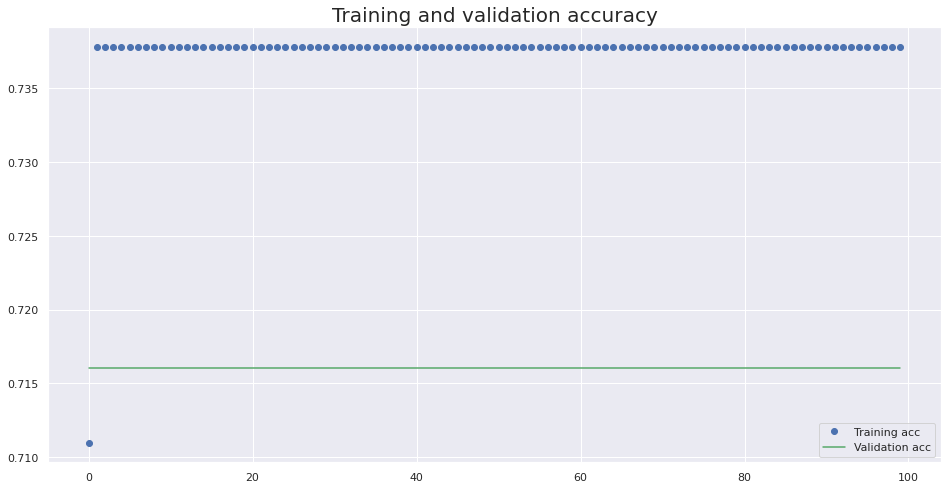

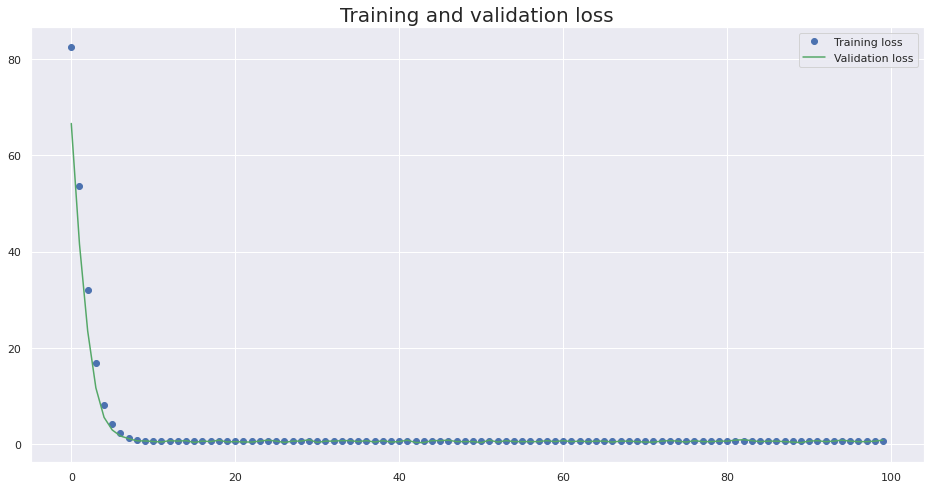

In [ ]:
plot_acc_and_loss(cnn_history)

## Augmented Model
Data Augmentation

Now, I will try to use Augmentation techniques to create dummy augmented data in order to increase the previous model accuracy as follows:

Shearing: pulling anyone off our photo and converting square into rhombus

Rotation: Rotating the image

Width shift: shift the image to the right or to the left

Height Shift: shifting whole image up and down

Zooming: zoom in at any particular section o our image.

Horizontal flip: mirror image along the vertical axis

In [ ]:
# Define The parameters of my image transformation
train_datagen = ImageDataGenerator(rotation_range=40, # rotating from -40 to40 degree
                               	width_shift_range=0.2, # allowing image generator to shift our images left or right  about 20% of total width
                               	height_shift_range=0.2,#allowing image generator to shift our images up or dowm  about 20% of total height
                               	shear_range=0.2,
                      	         zoom_range=0.2,
                               	horizontal_flip=True,
                               	fill_mode='nearest')
 

 
train_generator = train_datagen.flow_from_directory(
    	# This is the target directory
    	train_data_dir,
    	# All images will be resized to 150x150
    	target_size=(150, 150),
    	batch_size=32,
    	# Since we use binary_crossentropy loss, we need binary labels
    	class_mode='binary')
test_datagen = ImageDataGenerator(rescale=1./255) 
val_generator = test_datagen.flow_from_directory(val_data_dir,
                                                    	target_size=(150, 150),
     	                                               batch_size=32,
                                                    	class_mode='binary')


Found 3543 images belonging to 2 classes.
Found 1162 images belonging to 2 classes.


In [ ]:

# Always start the model with sequebtial function
model1 = Sequential()

# start adding layers and define the activation function of each layer as' relu', we define images in size 150x150
# in keras function for the convolution step is Conv2D

# input layer
model1.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model1.add(MaxPooling2D((2, 2)))

#  First Hidden 
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

# Second Hidden Layer
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

#  Third Hidden Layer
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

#Change all the layers dimension to vector through Fltten function
model1.add(Flatten())
# applying dropout layers to deactivate 50% of neurons during each epoch and randomly take,we will train the model with the rest 50% during each epoch
model1.add(Dropout(0.5))
# Adding the last layer before the output layer
model1.add(Dense(512, activation='relu'))
# Adding the output layer
model1.add(Dense(1, activation='sigmoid'))

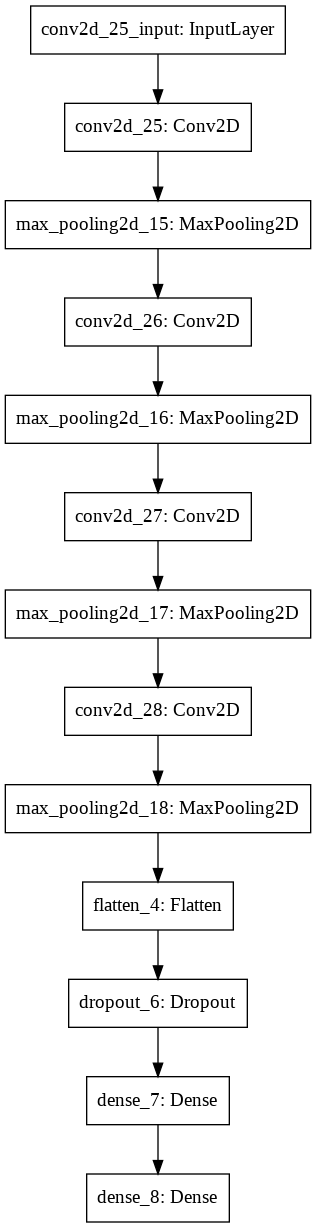

In [ ]:
plot_model(model1)
# looking at the structure of my neural network

In [ ]:
#compiling and Optimizing  model2
model1.compile(loss='binary_crossentropy',
          	optimizer=RMSprop(lr=1e-4),
          	metrics=['acc'])
 

In [ ]:
# fitting my model with training data
start = datetime.datetime.now()
history = model1.fit_generator(train_generator,
                          	steps_per_epoch=train_steps_per_epoch,# overall we are feeding 3200 images in every epoch of training our model because steps per epochs =100
                          	epochs=1,
                          	validation_data=val_generator,
                          	validation_steps=val_steps_per_epoch)

end = datetime.datetime.now()
elapsed = end - start 
print('---------Elapsed Time-----------')
print('Time to fit augmented model is:\n {}'.format(elapsed))


Epoch 1/100
100/100 [==============================] - 82s 819ms/step - loss: 1.3445 - acc: 0.6913 - val_loss: 0.6894 - val_acc: 0.7142
Epoch 2/100
100/100 [==============================] - 75s 747ms/step - loss: 0.5251 - acc: 0.7684 - val_loss: 0.6838 - val_acc: 0.7237
Epoch 3/100
100/100 [==============================] - 75s 748ms/step - loss: 0.4673 - acc: 0.7819 - val_loss: 0.6747 - val_acc: 0.7095
Epoch 4/100
100/100 [==============================] - 75s 752ms/step - loss: 0.4045 - acc: 0.8204 - val_loss: 0.6812 - val_acc: 0.7212
Epoch 5/100
100/100 [==============================] - 74s 742ms/step - loss: 0.4048 - acc: 0.8250 - val_loss: 0.6639 - val_acc: 0.7136
Epoch 6/100
100/100 [==============================] - 75s 746ms/step - loss: 0.3697 - acc: 0.8452 - val_loss: 0.6681 - val_acc: 0.7179
Epoch 7/100
100/100 [==============================] - 74s 744ms/step - loss: 0.3413 - acc: 0.8458 - val_loss: 0.6520 - val_acc: 0.7167
Epoch 8/100
100/100 [===========================

In [ ]:

results=store_results_to_dict(model1, 'Augmented Model')
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Testing Accuracy,Testing Loss,Training Accuracy,Training Loss,Validation Accuracy,validation Loss
0,"Base Model(with 4 conv,pooling layers,and dens...",0.879073,1.138494,1.000000,1.949158e-07,0.977820,9.190355e-04
1,"Hyperparameter tuned model(padding, adam)",0.848997,1.867431,1.000000,1.860358e-06,0.977186,1.730812e-10
2,"Regularized Model(Dropout, Ridge-Lasso)",0.722431,0.566893,0.729375,6.273807e-01,0.710393,8.693327e-01
3,Augmented Model,0.722431,0.946937,0.949375,2.397344e-01,0.711027,7.630190e-01


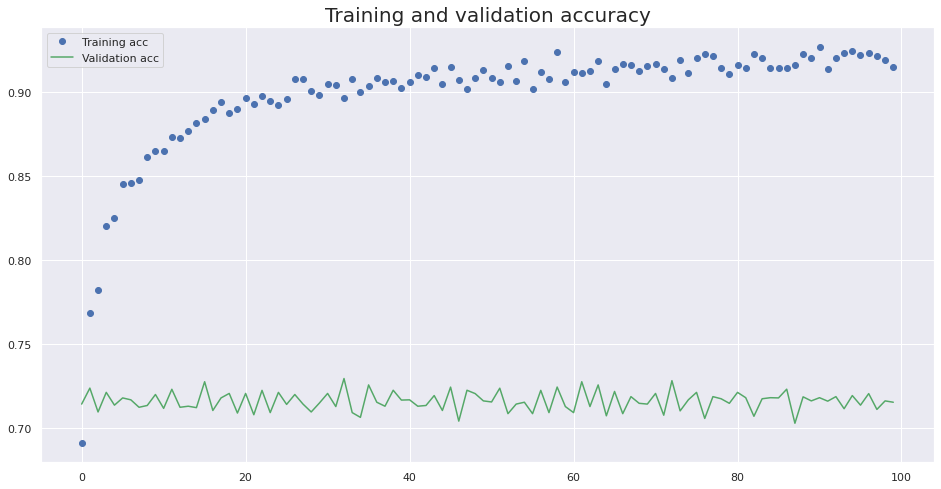

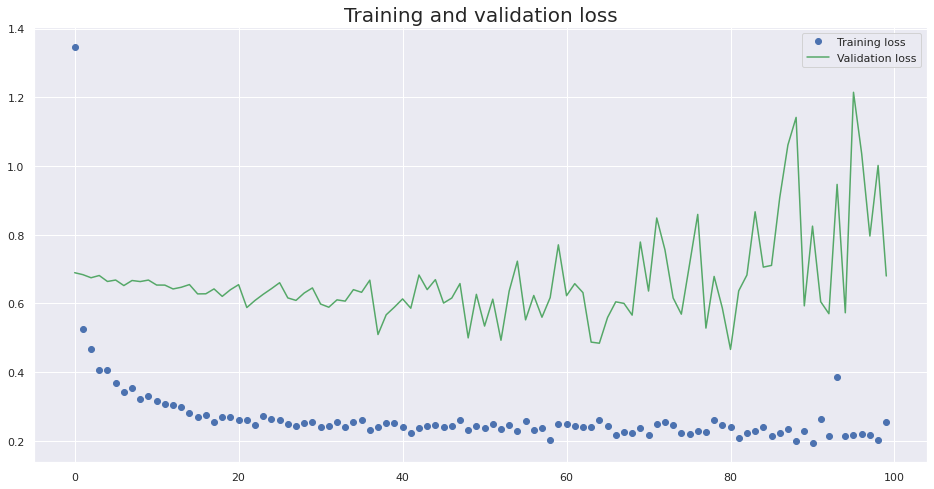

In [ ]:
plot_acc_and_loss(history)

# VGG16 Model


Transfer Learning Techniques,VGG16

We are going to use the architechure of the conventional pre trained model in our model. These models consist of two parts:convolutional base and fully connected neural network base. The convolutional base is used to identify features from the images,and then the fully connected neural network base is used to classify those features.

We can use pretrained convolutional base to extract features from our images. We can add three layers to classify this dataset.  We will use the convolutional base of VGG 16 model and the we will add one fully connected hidden layer and one output layer to classify features extracted from VGG 16 convolutional base. 

We will use pretrianed weight of Imagenet.We only want to use the convolutional part from the Imagenet modul.Since convolutional bases are reusable, they are mainly used to extract features and categorize images. 

In [ ]:
# Define The parameters of my image transformation
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40, # rotating from -40 to40 degree
                               	width_shift_range=0.2, # allowing image generator to shift our images left or right  about 20% of total width
                               	height_shift_range=0.2,#allowing image generator to shift our images up or dowm  about 20% of total height
                               	shear_range=0.2,
                      	         zoom_range=0.2,
                               	horizontal_flip=True,
                               	fill_mode='nearest')
 
test_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
    	# This is the target directory
    	train_data_dir,
    	# All images will be resized to 150x150
    	target_size=(150, 150),
    	batch_size=32,
    	# Since we use binary_crossentropy loss, we need binary labels
    	class_mode='binary')
 
val_generator = test_datagen.flow_from_directory(val_data_dir,
                                                    	target_size=(150, 150),
     	                                               batch_size=32,
                                                    	class_mode='binary')

Found 3543 images belonging to 2 classes.
Found 1162 images belonging to 2 classes.


In [ ]:
conv_base = VGG16(weights='imagenet',#imagenet is the final weight of vgg16 
                  include_top=False, #meaning we will import only the conv base not the whole thing
                  input_shape=(150,150,3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model2=Sequential()
model2.add(conv_base) #adding conv_base that was imported
model2.add(Flatten())
model2.add(Dense(256,activation='relu'))#adding fully connected dense layer with 256 neurons
model2.add(Dense(1,activation='sigmoid')) # output layer with single neuron

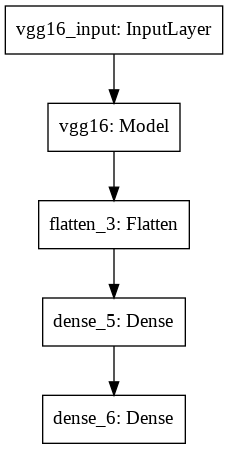

In [ ]:
#structure of model1
plot_model(model2)
# looking at the structure of my neural network

In [ ]:
model2.compile(loss='binary_crossentropy',
          	optimizer=RMSprop(lr=2e-5),# small learning rate used because weights already optimized
          	metrics=['acc'])
 
 

In [ ]:
start = datetime.datetime.now()
history = model2.fit_generator(train_generator,
                          	steps_per_epoch=train_steps_per_epoch,
                          	epochs=20,
                          	validation_data=val_generator,
                          	validation_steps=val_steps_per_epoch)
 
end = datetime.datetime.now()
elapsed = end - start 
print('---------Elapsed Time-----------')
print('Time to fit the VGG16 model is:\n {}'.format(elapsed))



Epoch 1/20
111/111 [==============================] - 71s 641ms/step - loss: 0.0531 - acc: 0.9814 - val_loss: 1.4274e-05 - val_acc: 0.9733
Epoch 2/20
111/111 [==============================] - 65s 589ms/step - loss: 0.0525 - acc: 0.9825 - val_loss: 0.0027 - val_acc: 0.9759
Epoch 3/20
111/111 [==============================] - 65s 588ms/step - loss: 0.0508 - acc: 0.9865 - val_loss: 4.8613e-04 - val_acc: 0.9802
Epoch 4/20
111/111 [==============================] - 65s 584ms/step - loss: 0.0515 - acc: 0.9859 - val_loss: 0.0412 - val_acc: 0.9742
Epoch 5/20
111/111 [==============================] - 65s 586ms/step - loss: 0.0492 - acc: 0.9839 - val_loss: 1.3046e-04 - val_acc: 0.9707
Epoch 6/20
111/111 [==============================] - 65s 584ms/step - loss: 0.0507 - acc: 0.9848 - val_loss: 0.0026 - val_acc: 0.9707
Epoch 7/20
111/111 [==============================] - 65s 585ms/step - loss: 0.0481 - acc: 0.9845 - val_loss: 7.1468e-05 - val_acc: 0.9518
Epoch 8/20
111/111 [===================

In [ ]:
results=store_results_to_dict(model2, 'Transfer Learning Model(VGG16)')
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Testing Accuracy,Testing Loss,Training Accuracy,Training Loss,Validation Accuracy,validation Loss,Train Accuracy,Train Loss,Test Accuracy,Test Loss,Precision,Recall,f1
0,"Base Model(with 4 conv,pooling layers,and dens...",0.736842,0.366598,0.8075,0.290411,0.775665,0.463487,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Transfer Learning Model(VGG16),NaN,NaN,NaN,NaN,0.970215,0.001311,0.993125,0.032232,0.952381,0.069387,0.0,0.0,0.0


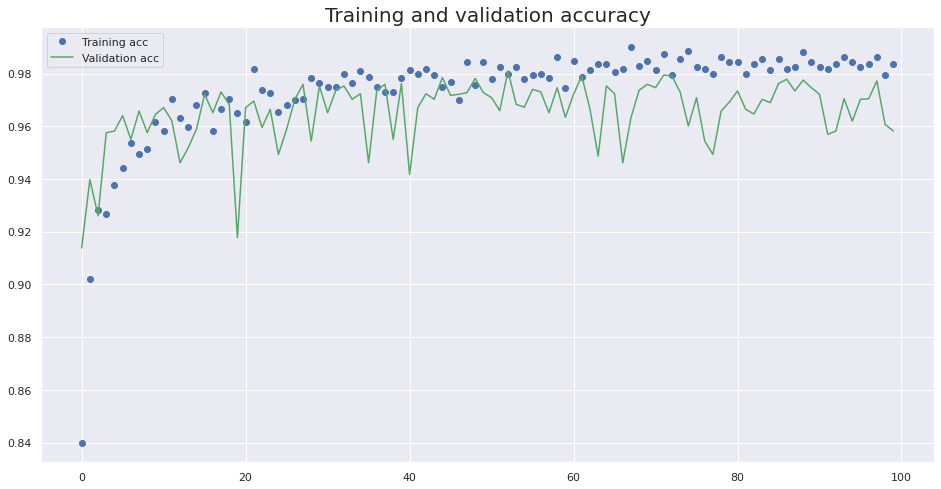

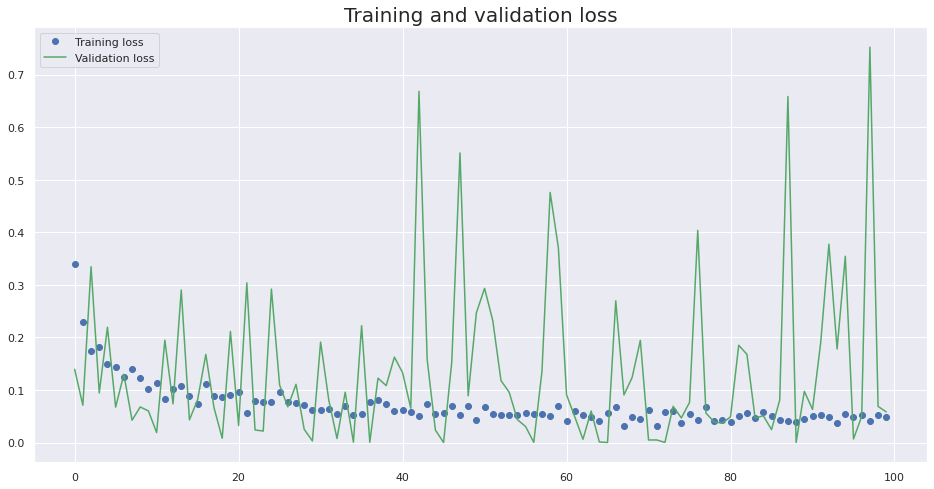

In [ ]:
plot_acc_and_loss(history)

In [ ]:
store_results_to_dict(model2, 'VGG16')

{'Model': 'VGG16',
 'Precision': 0.0,
 'Recall': 0.0,
 'Test Accuracy': 0.9486215710639954,
 'Test Loss': 0.21327641606330872,
 'Train Accuracy': 0.9918749928474426,
 'Train Loss': 0.37348249554634094,
 'Validation Accuracy': 0.9702154397964478,
 'f1': 0.0,
 'validation Loss': 0.06240329518914223}